# 🚀 KoBERT 모델 성능 최적화 업데이트 (2025-02-28)

## ✅ 추가된 주요 기능

### 🔹 1. 일반화 성능 향상을 위한 데이터 증강  
- 기존에 없던 **부정 데이터 추가**  
- 중립적인 부정 데이터 추가  

### 🔹 2. 학습률 및 스케줄링 개선  
- 🔥 **Cosine Decay 개선 적용**  
  - 에포크가 진행될수록 학습률을 점진적으로 낮추는 방식 최적화  
  - 기존보다 더 천천히 감소하도록 설정  

- 🔥 **학습률(lr) 미세 조정**  
  - 기존 `1.7e-5` → `1.5e-5` 로 변경  
  - 학습이 너무 급격히 수렴하는 것을 방지하여 일반화 성능 개선  

### 🔹 3. Regularization (일반화 기법) 강화  
- 🔧 **Weight Decay 증가**  
  - 기존 `0.01` → `0.02~0.03`으로 조정하여 과적합 방지  

- 🎭 **Dropout 확률 증가**  
  - 기존 `0.1` → `0.2`로 변경  
  - 모델이 특정 패턴에 과적합되는 것을 방지  

### 🔹 4. Gradient Accumulation 적용  
- **메모리 절약 및 일반화 성능 개선**  
- 기존보다 큰 batch size 효과를 얻기 위해 적용  

### 🔹 5. Model Checkpoint 개선  
- **각 에포크마다 성능이 개선되었을 경우 모델 저장**  
- 기존에는 마지막 에포크에서만 저장했지만, 이제는 **최적의 성능을 가진 에포크 기준으로 모델을 저장**  

---

## 📌 이번 업데이트의 목적  
- 학습 과정에서 과적합 방지  
- 최적의 하이퍼파라미터 조정을 통해 **일반화 성능 확대**  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import pandas as pd
import numpy as np
import time

In [2]:
import pandas as pd

# CSV 파일 경로 설정
file_path = "G:/내 드라이브/자료/멀티캠퍼스/최종 프로젝트/reviews_labeled2(GoogleAPI).csv"

# CSV 불러오기
df = pd.read_csv(file_path)

# 데이터 확인
print(f"✅ 데이터 로드 완료! 총 {len(df)}개 샘플")
#df.head()  # 첫 5개 데이터 출력

# ✅ 감정 라벨링 기준 적용
def label_sentiment(score, magnitude):
    if magnitude > 0.2 and score > 0.3:
        return "긍정"
    elif magnitude <= 0.2 or (-0.3 < score <= 0.3):
        return "중립"
    elif magnitude > 0.2 and score <= -0.3:
        return "부정"
    else:
        return "중립"  # 혹시 모를 예외 처리

# 새로운 'sentiment_label' 컬럼 생성
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row['label_score'], row['label_magnitude']), axis=1)
df['sentiment_label'].value_counts()

✅ 데이터 로드 완료! 총 340000개 샘플


sentiment_label
긍정    195144
중립    113641
부정     31215
Name: count, dtype: int64

In [3]:
import pandas as pd

# CSV 파일 경로 설정
file_path = "G://내 드라이브/자료/멀티캠퍼스/최종 프로젝트/데이터/reviews_completed_filtered.csv"

# CSV 불러오기 (// 경로 사용)
df_neg = pd.read_csv(file_path, encoding='cp949')

# 데이터 확인
print(f"✅ 데이터 로드 완료! 총 {len(df):,}개 샘플")

# 중복 데이터 제거 (전체 행이 중복된 경우만 제거)
df_neg = df_neg.drop_duplicates()

# sentence 컬럼이 비어 있는 경우 제거
df_neg = df_neg.dropna(subset=['sentence'])

# 데이터 확인
print(f"✅ 중복 및 결측값 제거 완료! 총 {len(df_neg):,}개 샘플 남음")

len(df_neg)

✅ 데이터 로드 완료! 총 340,000개 샘플
✅ 중복 및 결측값 제거 완료! 총 6,126개 샘플 남음


6126

In [4]:
import pandas as pd

# 변경 대상 필터링
mask = df['review_id'].isin(df_neg['review_id'])
neutral_mask = mask & (df['sentiment_label'] == "중립")
positive_mask = mask & (df['sentiment_label'] == "긍정")

# 중립 → 부정, 긍정 → 부정 개수 확인
num_neutral_changes = neutral_mask.sum()
num_positive_changes = positive_mask.sum()

# 변경된 행만 따로 저장
df_changed = df.loc[neutral_mask | positive_mask].copy()
df_changed['sentiment_label'] = "부정"  # 변경된 값 적용

# 변경된 데이터 CSV 저장
output_path = "G://내 드라이브/자료/멀티캠퍼스/최종 프로젝트/데이터/changed_sentiments.csv"
df_changed.to_csv(output_path, index=False, encoding='utf-8-sig')

# 전체 데이터에도 변경 사항 반영
df.loc[neutral_mask | positive_mask, 'sentiment_label'] = "부정"

# 결과 출력
print(f"✅ '중립' → '부정' 변경 개수: {num_neutral_changes:,}개")
print(f"✅ '긍정' → '부정' 변경 개수: {num_positive_changes:,}개")
print(f"✅ 총 변경된 개수: {num_neutral_changes + num_positive_changes:,}개")
print(f"✅ 변경된 데이터 저장 완료: {output_path}")

df['sentiment_label'].value_counts() #df에 변경내용 확인

✅ '중립' → '부정' 변경 개수: 2,866개
✅ '긍정' → '부정' 변경 개수: 1,073개
✅ 총 변경된 개수: 3,939개
✅ 변경된 데이터 저장 완료: G://내 드라이브/자료/멀티캠퍼스/최종 프로젝트/데이터/changed_sentiments.csv


sentiment_label
긍정    194071
중립    110775
부정     35154
Name: count, dtype: int64

In [5]:
# gpt가 만들어준 부정어 목록

negative_sentences = [
    "이거 진짜 후회됩니다.",
    "다시는 안 사요. 완전 별로였어요.",
    "불편해서 입지도 못하겠어요.",
    "싸길래 샀는데 품질이 너무 별로네요. 후회돼요.",
    "완전 실망했습니다. 다시는 안 삽니다.",
    "불편함 그 자체네요.",
    "다시 구매할 생각 없습니다.",
    "돈 아깝습니다. 정말 별로였어요.",
    "후회돼요. 진짜 실망입니다.",
    "사진이랑 다릅니다. 사지 마세요.",
    "이런 제품 처음 봐요. 최악이에요.",
    "입을 수가 없어요. 너무 불편해요.",
    "불량품이 왔습니다. 최악이네요.",
    "완전 후회 중입니다. 별로예요.",
    "이 돈 주고 샀다는 게 후회되네요.",
    "다시는 여기서 안 삽니다.",
    "불편해서 밖에서는 못 입겠어요.",
    "가성비 별로입니다. 기대 이하예요.",
    "세탁 한 번 했는데 망가졌어요.",
    "너무 불편해서 몇 번 입고 버렸어요.",
    "디자인은 괜찮은데 착용감 최악이에요.",
    "반품하고 싶어요. 품질이 엉망입니다.",
    "돈 낭비했습니다. 후회돼요.",
    "여태 산 것 중에 제일 별로예요.",
    "세탁 후 변형 심해요. 실망이에요.",
    "입으면 불편해서 오래 못 입어요.",
    "다시 구매? 절대 안 합니다.",
    "입을 때마다 불편해서 스트레스받아요.",
    "처음 샀을 때 기대했는데 후회돼요.",
    "이 브랜드 다시 이용 안 합니다.",
    "너무 불편해서 신고 다닐 수 없어요.",
    "재구매 절대 안 합니다. 별로예요.",
    "너무 실망스럽습니다. 후회돼요.",
    "다시 생각해도 최악의 선택이었어요.",
    "이 돈이면 더 좋은 거 살 걸 그랬어요.",
    "불편함이 너무 심해요.",
    "입고 나가니까 너무 불편해서 민망했어요.",
    "한 번 입었는데 불편해서 못 입겠어요.",
    "너무 실망스러워요. 다시는 안 살 거예요.",
    "이런 퀄리티는 처음 봅니다. 실망이에요.",
    "사진이랑 다르고 너무 불편합니다.",
    "한 번 세탁했더니 변형 심해요.",
    "불량이에요. 최악의 제품입니다.",
    "다시 구매할 일 절대 없어요.",
    "이렇게 불편한 제품은 처음이에요.",
    "이 브랜드 믿고 샀는데 후회됩니다.",
    "재구매? 절대 안 합니다.",
    "후회합니다. 다시는 안 살 거예요.",
    "싸길래 샀더니 역시나 후회됩니다.",
    "한 번 입고 버렸어요. 불편해요.",
    "불량이네요. 돈 아깝습니다.",
    "너무 불편해서 못 신고 다녀요.",
    "이 정도 퀄리티면 그냥 돈 버리는 거예요.",
    "너무 실망스러워요. 다시는 안 삽니다.",
    "입을 때마다 불편해서 신경 쓰여요.",
    "다시는 이 브랜드 안 삽니다.",
    "처음이자 마지막 구매입니다.",
    "별로네요. 기대 이하입니다.",
    "너무 불편해서 밖에 입고 나갈 수 없어요.",
    "사진과 다릅니다. 실망이에요.",
    "입고 몇 번 못 입었어요. 불편해요.",
    "후회 중입니다. 너무 별로예요.",
    "한 번 입고 다시는 안 입을 거예요.",
    "너무 별로예요. 후회돼요.",
    "가성비 생각하면 절대 비추입니다.",
    "세탁 한 번 했는데 엉망이 됐어요.",
    "기대했는데 너무 별로네요.",
    "이런 제품 처음 봐요. 최악입니다.",
    "입을 수가 없어요. 너무 불편해요.",
    "반품하고 싶어요. 너무 별로예요.",
    "완전 후회 중입니다. 별로예요.",
    "너무 별로라 다시는 안 삽니다.",
    "불편함이 너무 심합니다.",
    "세탁했더니 변형이 심해요. 실망이네요.",
    "너무 불편해서 몇 번 입고 버렸어요.",
    "디자인은 괜찮은데 착용감 최악이에요.",
    "반품하고 싶어요. 품질이 엉망입니다.",
    "돈 낭비했습니다. 후회돼요.",
    "여태 산 것 중에 제일 별로예요.",
    "세탁 후 변형 심해요. 실망이에요.",
    "입으면 불편해서 오래 못 입어요.",
    "다시 구매? 절대 안 합니다.",
    "입을 때마다 불편해서 스트레스받아요.",
    "처음 샀을 때 기대했는데 후회돼요.",
    "이 브랜드 다시 이용 안 합니다.",
    "너무 불편해서 신고 다닐 수 없어요.",
    "재구매 절대 안 합니다. 별로예요.",
    "너무 실망스럽습니다. 후회돼요.",
    "다시 생각해도 최악의 선택이었어요.",
    "이 돈이면 더 좋은 거 살 걸 그랬어요.",
    "불편함이 너무 심해요.",
    "입고 나가니까 너무 불편해서 민망했어요.",
    "한 번 입었는데 불편해서 못 입겠어요.",
    "너무 실망스러워요. 다시는 안 살 거예요.",
    "이런 퀄리티는 처음 봅니다. 실망이에요.",
    "사진이랑 다르고 너무 불편합니다.",
    "한 번 세탁했더니 변형 심해요.",
    "불량이에요. 최악의 제품입니다.",
    "다시 구매할 일 절대 없어요.",
    "이렇게 불편한 제품은 처음이에요.",
    "이 브랜드 믿고 샀는데 후회됩니다.",
    "재구매? 절대 안 합니다.",
    "후회합니다. 다시는 안 살 거예요.",
    "싸길래 샀더니 역시나 후회됩니다.",
    "한 번 입고 버렸어요. 불편해요.",
    "불량이네요. 돈 아깝습니다.",
    "너무 불편해서 못 신고 다녀요.",
    "이 정도 퀄리티면 그냥 돈 버리는 거예요.",
    "너무 실망스러워요. 다시는 안 삽니다.",
    "입을 때마다 불편해서 신경 쓰여요.",
    "다시는 이 브랜드 안 삽니다.",
    "처음이자 마지막 구매입니다.",
    "별로네요. 기대 이하입니다.",
    "너무 불편해서 밖에 입고 나갈 수 없어요.",
    "사진과 다릅니다. 실망이에요.",
    "입고 몇 번 못 입었어요. 불편해요.",
    "후회 중입니다. 너무 별로예요.",
    "진짜 최악이었어요.",
    "이렇게 별로일 줄 몰랐어요.",
    "이건 돈 낭비입니다.",
    "다시는 이용하고 싶지 않아요.",
    "구매한 걸 후회합니다.",
    "환불받고 싶어요.",
    "이 돈이면 다른 걸 샀을 거예요.",
    "사용할 가치가 없어요.",
    "실망 그 자체예요.",
    "이 정도 품질은 너무 심해요.",
    "정말 별로였어요, 절대 추천 안 해요.",
    "이 정도 가격에 이 품질이면 사기예요.",
    "한 번 쓰고 바로 버렸어요.",
    "완전 형편없었어요.",
    "어떻게 이렇게 만들었는지 이해가 안 가요.",
    "기대 이하도 한참 이하였어요.",
    "이런 제품은 처음 봐요, 최악이라는 의미로요.",
    "그냥 돈 버린 거 같아요.",
    "처음이자 마지막 구매입니다.",
    "이걸 살 바엔 차라리 안 사는 게 나아요.",
    "서비스도 별로고, 제품도 엉망이었어요.",
    "절대 다시 이용 안 할 거예요.",
    "이걸 만든 사람이 직접 써 봤는지 의문이에요.",
    "솔직히 대체 왜 이렇게 평이 좋은지 모르겠어요.",
    "너무 실망해서 말이 안 나와요.",
    "이렇게 불친절한 곳은 처음이에요.",
    "배송이 너무 늦고, 제품도 문제 많았어요.",
    "돈이 아까운 수준이에요.",
    "후회만 남아요.",
    "한 마디로 최악이었어요.",
    "기대보단 별로였어요.",
    "그냥 보통보다 못해요.",
    "딱히 좋다고 말하긴 어렵네요.",
    "한 번 써봤는데 다시 쓰긴 애매해요.",
    "별 기대 안 했는데 역시나였어요.",
    "가격 대비 성능이 좀 아쉬워요.",
    "괜찮을 줄 알았는데 아닌 것 같아요.",
    "뭔가 부족한 느낌이 있어요.",
    "그냥 평범한데 그마저도 아쉬워요.",
    "사용감이 생각보다 별로였어요.",
    "추천은 못 하겠어요.",
    "좋다고 하긴 좀 그렇네요.",
    "한 번쯤은 써볼 만하지만 재구매는 없을 것 같아요.",
    "기능이 부족한 느낌이에요.",
    "소문보단 별로였어요.",
    "막 나쁘진 않은데 좋은 점을 모르겠어요.",
    "솔직히 딱히 장점이 안 보여요.",
    "그냥 무난한데 그 이상은 아니에요.",
    "완전히 별로라고는 못 하겠지만 다시 사진 않을 거예요.",
    "그냥 그래요, 특별할 게 없어요.",
    "문제가 없진 않은데 참을 만한 수준이에요.",
    "크게 나쁜 건 아니지만 추천하고 싶진 않아요.",
    "이 가격대에선 더 나은 선택지가 있을 것 같아요.",
    "전반적으로 아쉬운 느낌이에요.",
    "무난하긴 한데 부족한 점이 많아요.",
    "사용하면서 불편한 점이 계속 생겨요.",
    "기능은 다 있는데 뭔가 어설퍼요.",
    "괜찮다고 하기엔 애매해요.",
    "쓸 수는 있지만 만족스럽진 않아요.",
    "진짜 왜 이걸 샀는지 모르겠어요.",
    "사용할 때마다 짜증 나요.",
    "하나도 기대에 못 미쳐요.",
    "평이 좋아서 샀는데 거짓말이었어요.",
    "차라리 안 샀으면 좋았을 걸요.",
    "사진과 완전히 달라요.",
    "싸다고 다 좋은 게 아니란 걸 깨달았어요.",
    "설명과 완전 달라요.",
    "성능이 너무 구려요.",
    "한 번만 써도 문제가 생겨요.",
    "이렇게 불편한 제품은 처음이에요.",
    "이 돈 주고 사기엔 부족한 점이 너무 많아요.",
    "왜 인기가 있는지 도저히 이해가 안 가요.",
    "이거 사용할 바엔 그냥 안 쓰는 게 나아요.",
    "너무 기대했나 봐요.",
    "가격이 싼 이유가 있었네요.",
    "이 제품이 잘 팔린다는 게 신기할 정도예요.",
    "기능도 별로고, 디자인도 촌스러워요.",
    "생각보다 훨씬 별로예요.",
    "이 정도 퀄리티면 환불받아야 한다고 봐요.",
    "사용하면서 계속 불만이 생겨요.",
    "살면서 이렇게 실망한 적이 없어요.",
    "차라리 중고를 사는 게 나았을 거예요.",
    "이건 그냥 실패작이에요.",
    "성능이 너무 나빠서 짜증 나요.",
    "불량인지 원래 이런 건지 모르겠어요.",
    "이런 걸 추천하는 사람도 이해가 안 가요.",
    "이건 그냥 장난감 수준이에요.",
    "이거 쓸 바엔 그냥 손으로 하는 게 나아요.",
    "딱히 나쁘진 않지만 만족스럽지도 않아요.",
    "그냥 무난하지만 추천하고 싶진 않아요.",
    "아주 별로는 아닌데 다시 사긴 싫어요.",
    "그냥저냥 쓸 수는 있지만 딱 거기까지예요.",
    "정말 좋았으면 좋았을 텐데요.",
    "이 정도면 그럭저럭인데 다시 사진 않을 거예요.",
    "어디에 쓰느냐에 따라 다르겠지만 별로예요.",
    "그냥 있으면 쓰지만 없으면 딱히 아쉬울 건 없어요.",
    "쓸 수는 있는데 불편함이 많아요.",
    "싼 맛에 샀는데 그 이상을 바라면 안 될 것 같아요.",
    "그냥 단순히 가격만 보고 산다면 괜찮을 수도 있어요.",
    "사용하다 보니 불편한 점이 자꾸 보이네요.",
    "처음엔 괜찮았는데 계속 쓰다 보니 별로예요.",
    "디자인은 괜찮은데 성능이 많이 아쉬워요.",
    "이 가격에 기대할 게 없긴 하죠.",
    "사실상 돈 낭비까지는 아닌데 만족도는 낮아요.",
    "처음엔 좋아 보였는데 점점 단점이 보이네요.",
    "만족할 줄 알았는데 기대가 너무 컸나 봐요.",
    "고민 끝에 샀지만 기대엔 못 미쳤어요.",
    "분명 장점도 있지만 단점이 너무 커요.",
    "디자인은 괜찮지만 성능이 부족해요.",
    "사기당한 기분이네요. 다시는 안 삽니다.",
    "디자인만 멀쩡하고 성능은 꽝이에요",
    "진짜 최악이네요. 다시는 안 사요.",
    "이거 돈 아깝네요. 후회됩니다.",
    "완전 쓰레기입니다. 버렸어요.",
    "이렇게 별로일 줄 몰랐어요. 실망이에요.",
    "절대 추천 안 합니다.",
    "이걸 사고 후회만 남았어요.",
    "사진과 완전히 다릅니다. 사기당한 기분이에요.",
    "처음부터 안 사는 게 정답이었어요.",
    "뭔가 잘못 만들어진 제품 같아요.",
    "너무 별로라 당황스럽네요.",
    "이 가격이면 차라리 다른 걸 사는 게 나아요.",
    "사용감이 정말 최악이에요.",
    "왜 이렇게 후기가 좋은지 이해가 안 가요.",
    "구매한 걸 후회합니다.",
    "불량인가 싶을 정도로 엉망이에요.",
    "진짜로 돈 버린 기분이에요.",
    "품질이 너무 안 좋아서 짜증나요.",
    "이 정도면 그냥 실패작이에요.",
    "이렇게 형편없는 제품은 처음 봐요.",
    "성능이 너무 엉망이에요.",
    "이건 진짜 아닌 것 같아요.",
    "설명과 다릅니다. 속았어요.",
    "너무 불편해서 못 쓰겠어요.",
    "디자인도 별로고 기능도 별로예요.",
    "이 정도 퀄리티면 환불받아야죠.",
    "사용하면서 계속 불편함이 느껴집니다.",
    "사기당한 기분이네요. 다시는 안 삽니다.",
    "배송도 느리고 품질도 별로예요.",
    "한 번 써보고 바로 버렸어요.",
    "완전 후회되는 구매입니다.",
    "싸다고 다 좋은 건 아니란 걸 깨달았어요.",
    "제대로 된 제품인지 의심스럽네요.",
    "하자가 너무 많아요.",
    "사용하는 내내 불만이 생겼어요.",
    "고민할 필요 없이 안 사는 게 답입니다.",
    "비슷한 제품 중 최악이에요.",
    "이걸 돈 주고 샀다는 게 후회됩니다.",
    "이 정도면 그냥 장난감 수준이네요.",
    "디자인만 멀쩡하고 성능은 꽝이에요.",
    "처음부터 다시 만들었으면 좋겠네요.",
    "여러모로 실망스러운 제품이에요.",
    "딱 한 번만 쓰고 싶은 제품이에요.",
    "차라리 공짜로 줘도 안 쓸 것 같아요.",
    "이렇게 별로일 거라고는 상상도 못 했어요.",
    "사용할수록 점점 더 불편해집니다.",
    "마감 처리가 너무 허술합니다.",
    "한마디로 최악입니다.",
    "이걸 만든 사람이 직접 써봤을까요?",
    "비싸기만 하고 전혀 쓸모가 없어요.",
    "가격을 생각하면 정말 형편없네요.",
    "이거 그냥 돈 날린 거예요.",
    "처음이자 마지막 구매입니다.",
    "아무리 생각해도 돈이 아까워요.",
    "이렇게 불편한 제품은 처음이에요.",
    "완전 별로라서 말도 안 나오네요.",
    "추천을 못 하겠습니다.",
    "한 번 사보고 실망한 제품이에요.",
    "딱 한 마디로 정의하면 쓰레기입니다.",
    "시간 지나면 더 후회될 것 같아요.",
    "싼 이유가 있었네요.",
    "왜 샀는지 모르겠어요.",
    "지금까지 산 것 중 최악입니다.",
    "이 제품이 인기가 많다는 게 이해가 안 가요.",
    "제발 사지 마세요. 후회합니다.",
    "환불받고 싶은데 불가능하네요.",
    "이런 제품이 존재하는 게 신기해요.",
    "별 기대도 안 했는데 더 별로였어요.",
    "별로라고 생각했지만 예상보다 더 별로예요.",
    "생각보다 별로였어요.",
    "기대가 너무 컸던 걸까요?",
    "그냥 평범한데 그 마저도 아쉬워요.",
    "가격 대비 성능이 아쉽네요.",
    "무난한데 다시 사고 싶진 않아요.",
    "사용할 만하지만 좋은 점을 모르겠어요.",
    "다른 제품과 비교하면 부족한 점이 많아요.",
    "사용하다 보니 불편한 점이 많네요.",
    "어디에 쓰느냐에 따라 다르겠지만 저는 별로예요.",
    "특별히 좋다고 느껴지진 않았어요.",
    "나쁜 건 아닌데 좋은 점도 모르겠어요.",
    "생각보다 기능이 부족하네요.",
    "괜찮은 듯했지만 점점 실망스럽네요.",
    "기능이 전반적으로 미흡해요.",
    "사용하다 보니 점점 단점이 보이네요.",
    "조금 더 신경 써서 만들었다면 좋았을 것 같아요.",
    "이 가격이면 기대보다 못 미쳐요.",
    "괜찮긴 한데 다시 사지는 않을 것 같아요.",
    "딱히 좋은지도 모르겠어요.",
    "만족스럽진 않네요.",
    "한 번쯤은 써볼 만하지만 추천하진 않아요.",
    "솔직히 딱히 장점이 없어요.",
    "가격이 낮아서 그냥 샀지만 아쉬운 점이 많아요.",
    "무난하지만 그 이상은 아니에요.",
    "사용할 수는 있지만 불편해요.",
    "다른 걸 살 걸 그랬어요.",
    "뭔가 부족한 느낌이 있어요.",
    "그냥 보통보다 못한 수준이에요.",
    "평범한데 만족스럽진 않아요.",
    "그럭저럭 쓰긴 하지만 추천하고 싶진 않아요.",
    "한 번쯤 써볼 만하지만 다시 사진 않을 것 같아요.",
    "성능이 기대에는 못 미쳤어요.",
    "고민 끝에 샀지만 만족스럽진 않아요.",
    "이 제품을 쓰고 나니 기대가 낮아졌어요.",
    "기능이 있긴 한데 너무 제한적이에요.",
    "처음에는 괜찮은 줄 알았는데 다시 보니 아쉽네요.",
    "이 가격이라면 더 좋은 선택지가 있을 것 같아요.",
    "디자인은 괜찮지만 성능이 부족해요.",
    "사용하면 할수록 아쉬운 점이 많아지네요.",
    "기능이 다 있긴 한데 뭔가 어설퍼요.",
    "이 가격이면 그냥 그럴 만한 제품이에요.",
    "기능적인 면에서 실망스럽네요."
]

In [6]:
import pandas as pd

# 부정 문장 리스트에서 최대 500개 가져오기
subset_sentences = negative_sentences[:500]

# 새로운 데이터프레임 생성 (길이 자동 맞춤)
new_data = pd.DataFrame({
    "sentence": subset_sentences,
    "sentiment_label": ["부정"] * len(subset_sentences)  # 길이를 자동으로 맞춤
})

# 기존 df에 추가
df = pd.concat([df, new_data], ignore_index=True)

# 결과 확인
df['sentiment_label'].value_counts() #df에 변경내용 확인

sentiment_label
긍정    194071
중립    110775
부정     35492
Name: count, dtype: int64

In [7]:
from sklearn.utils import resample

# 3️⃣ 언더샘플링 기준 설정 (최소 클래스인 '부정' 개수에 맞춤)
min_class_count = df['sentiment_label'].value_counts().min()

df_pos = df[df['sentiment_label'] == '긍정']
df_neu = df[df['sentiment_label'] == '중립']
df_neg = df[df['sentiment_label'] == '부정']

# 4️⃣ 긍정과 중립 데이터를 부정 데이터 개수에 맞춰 다운샘플링
df_pos_downsampled = resample(df_pos, replace=False, n_samples=int(min_class_count*0.7), random_state=42)
df_neu_downsampled = resample(df_neu, replace=False, n_samples=int(min_class_count*0.7), random_state=42)

# 5️⃣ 언더샘플링된 데이터 병합
df_balanced = pd.concat([df_pos_downsampled, df_neu_downsampled, df_neg], ignore_index=True)

# ✅ 최종 데이터 개수 출력
print("✅ 다운샘플링 완료! 클래스별 샘플 개수:")
print(df_balanced["sentiment_label"].value_counts())

✅ 다운샘플링 완료! 클래스별 샘플 개수:
sentiment_label
부정    35492
긍정    24844
중립    24844
Name: count, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split

# ✅ 90% 학습, 5% 검증, 5% 테스트로 분리
train_df, temp_df = train_test_split(df_balanced, test_size=0.1, random_state=42, stratify=df_balanced["sentiment_label"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["sentiment_label"])

print("🔥 데이터셋 분할 완료!")
print(f"👉 학습 데이터 개수: {len(train_df)}")
print(f"👉 검증 데이터 개수: {len(val_df)}")
print(f"👉 테스트 데이터 개수: {len(test_df)}")

🔥 데이터셋 분할 완료!
👉 학습 데이터 개수: 76662
👉 검증 데이터 개수: 4259
👉 테스트 데이터 개수: 4259


In [9]:
# ✅ 데이터셋 클래스 정의
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df["sentence"].tolist()
        self.labels = df["sentiment_label"].map({"부정": 0, "중립": 1, "긍정": 2}).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

from transformers import AutoTokenizer

# ✅ 토크나이저 불러오기
model_name = "monologg/kobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

In [10]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, get_scheduler

# ✅ 기존 모델 가중치 불러오기
model_path = "G://내 드라이브//자료//멀티캠퍼스//최종 프로젝트//best_model_with_val(250227).pth"
model = AutoModelForSequenceClassification.from_pretrained("monologg/kobert", num_labels=3)
model.load_state_dict(torch.load(model_path, map_location="cuda", weights_only=True), strict=False)


# 🔥 Dropout 증가 (기존 0.1 → 0.2)
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.2  # Dropout 확률 증가

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ 데이터 로드 (train_df, val_df, test_df 사용)
train_dataset = SentimentDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = SentimentDataset(val_df, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = SentimentDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# ✅ 최적화 설정 (학습률 1.5e-5, L2 정규화 weight_decay 증가)
optimizer = AdamW(model.parameters(), lr=1.56e-5, weight_decay=0.025)  # 🔥 weight_decay 증가

# ✅ 학습 스케줄러 설정 (Cosine Decay 개선)
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * 12,  # 12 Epoch
)

# ✅ Gradient Accumulation 적용 (메모리 최적화)
gradient_accumulation_steps = 4  # 🔥 추가
num_epochs = 12  # 🔥 Epoch 유지
best_loss = float("inf")  # ✅ 최적 모델 저장용


In [13]:
# 🔥 Focal Loss 함수 추가
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [16]:
# ✅ Focal Loss 적용
criterion = FocalLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad()  # 🔥 Gradient Accumulation 적용을 위해 변경

    tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for step, batch in enumerate(tqdm_bar):
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=inputs, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)  # 🔥 Focal Loss 적용

        loss = loss / gradient_accumulation_steps  # 🔥 Gradient Accumulation 적용
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:  # 🔥 Gradient Accumulation step마다 업데이트
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item()
        correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

        tqdm_bar.set_postfix(loss=f"{total_loss/(step+1):.4f}", acc=f"{correct/total:.4f}")

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    # ✅ 검증 데이터 평가
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=inputs, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            val_loss += loss.item()
            val_correct += (outputs.logits.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    print(f"📢 Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # ✅ 검증 loss 개선되면 모델 저장
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), "G:/내 드라이브/자료/멀티캠퍼스/최종 프로젝트/best_model_with_val(250228).pth")
        print("💾 새로운 최적 모델 저장됨!")

Epoch 1/12: 100%|█████████████████████████████████████████| 1198/1198 [52:00<00:00,  2.60s/it, acc=0.9112, loss=0.0243]


📢 Epoch 1/12 | Train Loss: 0.0243 | Train Acc: 0.9112 | Val Loss: 0.0742 | Val Acc: 0.9305
💾 새로운 최적 모델 저장됨!


Epoch 2/12: 100%|█████████████████████████████████████████| 1198/1198 [48:01<00:00,  2.41s/it, acc=0.9167, loss=0.0208]


📢 Epoch 2/12 | Train Loss: 0.0208 | Train Acc: 0.9167 | Val Loss: 0.0695 | Val Acc: 0.9338
💾 새로운 최적 모델 저장됨!


Epoch 3/12: 100%|█████████████████████████████████████████| 1198/1198 [47:34<00:00,  2.38s/it, acc=0.9218, loss=0.0189]


📢 Epoch 3/12 | Train Loss: 0.0189 | Train Acc: 0.9218 | Val Loss: 0.0694 | Val Acc: 0.9291
💾 새로운 최적 모델 저장됨!


Epoch 4/12: 100%|█████████████████████████████████████████| 1198/1198 [48:12<00:00,  2.41s/it, acc=0.9266, loss=0.0176]


📢 Epoch 4/12 | Train Loss: 0.0176 | Train Acc: 0.9266 | Val Loss: 0.0735 | Val Acc: 0.9307


Epoch 5/12: 100%|█████████████████████████████████████████| 1198/1198 [49:22<00:00,  2.47s/it, acc=0.9329, loss=0.0156]


📢 Epoch 5/12 | Train Loss: 0.0156 | Train Acc: 0.9329 | Val Loss: 0.0734 | Val Acc: 0.9293


Epoch 6/12:   9%|███▊                                      | 110/1198 [03:53<38:26,  2.12s/it, acc=0.9344, loss=0.0154]


KeyboardInterrupt: 

In [17]:
# 테스트 데이터로 성능 테스트 진행

import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from tqdm import tqdm

# ✅ 저장된 모델 불러오기
model_path = "G:/내 드라이브/자료/멀티캠퍼스/최종 프로젝트/best_model_with_val(250228).pth"
model = AutoModelForSequenceClassification.from_pretrained("monologg/kobert", num_labels=3)
model.load_state_dict(torch.load(model_path, map_location="cuda"))  # 모델 가중치 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # 평가 모드 전환

# ✅ 테스트 데이터 로드
test_dataset = SentimentDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 예측값 저장 리스트
all_preds = []
all_labels = []

# ✅ 모델 예측 수행
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# ✅ 평가 결과 출력
print("\n🔥 테스트 결과 🔥")
print(classification_report(all_labels, all_preds, target_names=["부정", "중립", "긍정"]))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39764\2569702182.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor


🔥 테스트 결과 🔥
              precision    recall  f1-score   support

          부정       0.97      0.90      0.93      1774
          중립       0.89      0.91      0.90      1242
          긍정       0.92      0.98      0.95      1243

    accuracy                           0.93      4259
   macro avg       0.92      0.93      0.93      4259
weighted avg       0.93      0.93      0.93      4259



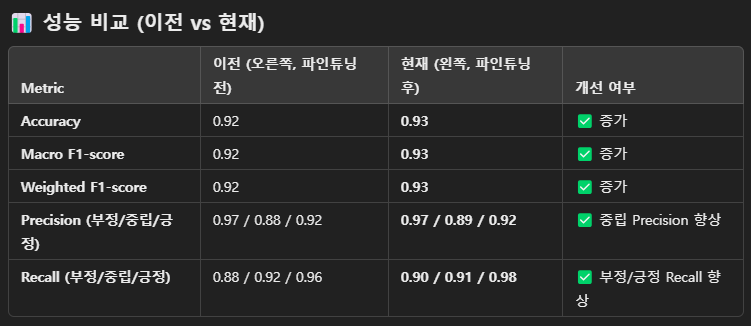

In [18]:
## 모델 활용법문장 넣어서 분류
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

# ✅ 모델 경로 설정
model_path = "G:/내 드라이브/자료/멀티캠퍼스/최종 프로젝트/best_model_with_val(250228).pth"
model_name = "monologg/kobert"  # KoBERT 기반 모델

# ✅ 토크나이저 & 모델 로드 (GPU 사용 가능하면 CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # 평가 모드

# ✅ 감성 분석 함수 (문장 입력 → 감성 예측)
def predict_sentiment(sentence):
    """ 문장을 입력하면 감성(긍정, 중립, 부정)과 확률을 반환하는 함수 """
    
    # 파일 경로 설정
    products_file = r'G:\내 드라이브\자료\멀티캠퍼스\최종 프로젝트\데이터\Products.csv'
    reviews_file = r'G:\내 드라이브\자료\멀티캠퍼스\최종 프로젝트\데이터\Reviews.csv'

    # CSV 파일 불러오기
    products_df = pd.read_csv(products_file, encoding='cp949', dtype={'product_id': str})
    reviews_df = pd.read_csv(reviews_file, encoding='utf-8', dtype={'product_id': str, 'review_id': str})
    
    # 1️⃣ 문장 토큰화
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # 2️⃣ 모델 예측
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)  # 확률 변환
    
    # 3️⃣ 예측값 변환
    predicted_label = torch.argmax(probs, dim=1).item()
    confidence = probs.squeeze().tolist()  # 확률 리스트

    # 4️⃣ 라벨 매핑
    labels = {0: "부정", 1: "중립", 2: "긍정"}
    sentiment = labels[predicted_label]

    # 5️⃣ 결과 출력
    print(f"📌 입력 문장: {sentence}")
    print(f"🎯 감성 예측: {sentiment}")
    print(f"📊 확률: 부정({confidence[0]:.4f}) | 중립({confidence[1]:.4f}) | 긍정({confidence[2]:.4f})")
    
    return sentiment, confidence  # (감성, 확률)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39764\1506835283.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

In [22]:
sentence = "재구매의사 없습니다"
predict_sentiment(sentence)

📌 입력 문장: 재구매의사 없습니다
🎯 감성 예측: 부정
📊 확률: 부정(0.9959) | 중립(0.0036) | 긍정(0.0004)


('부정', [0.9959341287612915, 0.0036387601867318153, 0.00042702947393991053])